In [1]:
# =============================================================================
# QUESTION: Do the same agents regularly handle policies with unusual claim amounts?
# =============================================================================

In [3]:
# -----------------------------
# STEP 1: Setup and clean
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

# Load data
df = pd.read_csv('Insurance_Project.csv')
print("Total claims: " , (len(df)))

# Quick cleanup: drop missing essential data
df_clean = df.dropna(subset=['AGENT_ID', 'CLAIM_AMOUNT'])

Total claims:  10000


In [6]:
# =============================================================================
# STEP 2: DATA CLEANING AND FILTERING
# =============================================================================
# Replace missing values, remove duplicates, standardize categories

#---------------------------------------
# CHECK MISSING VALUES FIRST
#---------------------------------------
print("Missing values before cleaning:")
print(df[['AGENT_ID', 'CLAIM_AMOUNT']].isnull().sum())

#----------------------------------------
# FILL MISSING NUMERIC VALUES WITH 0
#----------------------------------------
df['CLAIM_AMOUNT'] = df['CLAIM_AMOUNT'].fillna(0)

#---------------------------------------------------
# FILL MISSING CATEGORICAL VALUES WITH 'UNKNOWN'
#---------------------------------------------------
df['AGENT_ID'] = df['AGENT_ID'].fillna('UNKNOWN')

#---------------------------------------------------
# REMOVE DUPLICATES
#---------------------------------------------------
df_clean = df.drop_duplicates()

print("Missing values after cleaning:")
print(df_clean[['AGENT_ID', 'CLAIM_AMOUNT']].isnull().sum())
print("Total claims after cleaning: " , len(df_clean))

Missing values before cleaning:
AGENT_ID        0
CLAIM_AMOUNT    0
dtype: int64
Missing values after cleaning:
AGENT_ID        0
CLAIM_AMOUNT    0
dtype: int64
Total claims after cleaning:  10000


In [8]:
# =============================================================================
# STEP 3: DEFINE UNUSUAL CLAIMS AND PREPARE DATA
# =============================================================================

#---------------------------------------
# CALCULATE CLAIM AMOUNT STATISTICS
#---------------------------------------
claim_mean = df_clean['CLAIM_AMOUNT'].mean()
claim_std = df_clean['CLAIM_AMOUNT'].std()
percentile_75 = df_clean['CLAIM_AMOUNT'].quantile(0.75)
percentile_90 = df_clean['CLAIM_AMOUNT'].quantile(0.90)

print("Claim Amount")
print("Mean claim amount: ", round(claim_mean, 2))
print("Standard deviation: ", round(claim_std, 2))
print("75th percentile: ", round(percentile_75, 2))
print("90th percentile: ", round(percentile_90, 2))

#---------------------------------------
# DEFINE UNUSUAL CLAIMS (TOP 25% HIGHEST)
#---------------------------------------
df_clean['UNUSUAL_CLAIM'] = df_clean['CLAIM_AMOUNT'] > percentile_75

print("\nUnusual Claims Summary")
print("Total unusual claims (above 75th percentile): ", df_clean['UNUSUAL_CLAIM'].sum())
print("Percentage of unusual claims: ", round((df_clean['UNUSUAL_CLAIM'].sum() / len(df_clean) * 100), 2), "%")

#---------------------------------------
# PREPARE AGENT-LEVEL DATA
#---------------------------------------
agent_stats = df_clean.groupby('AGENT_ID').agg({
    'CLAIM_AMOUNT': ['count', 'mean'],
    'UNUSUAL_CLAIM': 'sum'
}).round(3)

# Flatten column names
agent_stats.columns = ['TOTAL_CLAIMS', 'AVG_CLAIM_AMOUNT', 'UNUSUAL_CLAIMS_COUNT']

# Calculate percentage of unusual claims per agent
agent_stats['UNUSUAL_CLAIMS_PCT'] = (agent_stats['UNUSUAL_CLAIMS_COUNT'] / agent_stats['TOTAL_CLAIMS'] * 100).round(2)

print("\nAgent Statistics Prepared")
print("Total agents analyzed: ", len(agent_stats))
print("Average claims per agent: ", round(agent_stats['TOTAL_CLAIMS'].mean(), 2))
print("Average unusual claims percentage: ", round(agent_stats['UNUSUAL_CLAIMS_PCT'].mean(), 2), "%")

Claim Amount
Mean claim amount:  16563.83
Standard deviation:  22037.49
75th percentile:  21000.0
90th percentile:  45000.0

Unusual Claims Summary
Total unusual claims (above 75th percentile):  2465
Percentage of unusual claims:  24.65 %

Agent Statistics Prepared
Total agents analyzed:  1200
Average claims per agent:  8.33
Average unusual claims percentage:  24.68 %


In [10]:
#quick notes: 
#
# The 25% highest amounts
#Each agent handle at least 8 cases
#Expected that 2 claims are unsual

In [30]:
# =============================================================================
# STEP 4: IDENTIFY AGENTS WITH SUSPICIOUS PATTERNS
# =============================================================================
# Find agents with high frequency of unusual claims and visualize patterns

#---------------------------------------
# FILTER AGENTS WITH MULTIPLE UNUSUAL CLAIMS
#---------------------------------------
agents_4plus_unusual = agent_stats[agent_stats['UNUSUAL_CLAIMS_COUNT'] >= 4]
agents_high_percentage = agent_stats[agent_stats['UNUSUAL_CLAIMS_PCT'] > 50]

print("AGENTS WITH 4+ UNUSUAL CLAIMS")
print("=" * 40)
print("Total agents with 4+ unusual claims: ", len(agents_4plus_unusual))

print("\nAGENTS WITH HIGH PERCENTAGE (>50%) OF UNUSUAL CLAIMS")
print("=" * 55)
print("Total agents with >50% unusual claims: ", len(agents_high_percentage))

AGENTS WITH 4+ UNUSUAL CLAIMS
Total agents with 4+ unusual claims:  184

AGENTS WITH HIGH PERCENTAGE (>50%) OF UNUSUAL CLAIMS
Total agents with >50% unusual claims:  54



 FIND EXTREME OUTLIERS AMONG AGENTS
Extreme outlier agents (z-score > 2): 42


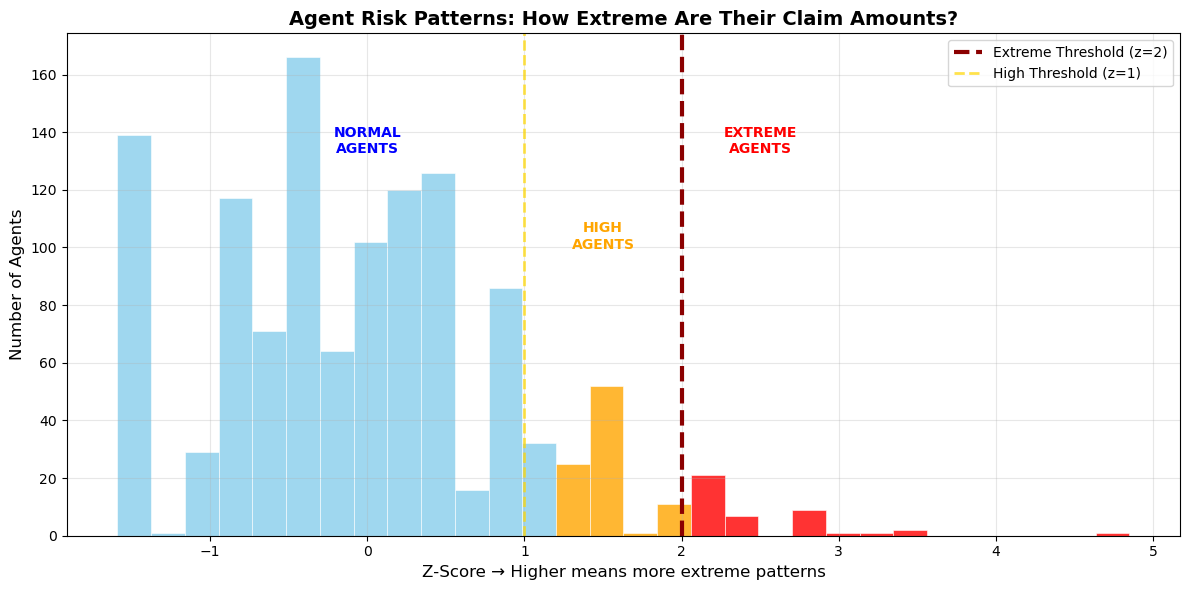


TOP 10 MOST EXTREME AGENTS:
AGENT01161 : z-score 4.85 - 100.0 % unusual claims
AGENT00010 : z-score 3.56 - 80.0 % unusual claims
AGENT01046 : z-score 3.56 - 80.0 % unusual claims
AGENT00384 : z-score 3.24 - 75.0 % unusual claims
AGENT00037 : z-score 3.01 - 71.43 % unusual claims
AGENT00106 : z-score 2.7 - 66.67 % unusual claims
AGENT00181 : z-score 2.7 - 66.67 % unusual claims
AGENT00285 : z-score 2.7 - 66.67 % unusual claims
AGENT00376 : z-score 2.7 - 66.67 % unusual claims
AGENT00454 : z-score 2.7 - 66.67 % unusual claims

CONCLUSION: Found 42 agents with statistically extreme patterns
These agents handle unusually high-value claims consistently


In [34]:
# =============================================================================
# Z-SCORE - FIND EXTREME OUTLIERS
# =============================================================================

print("\n FIND EXTREME OUTLIERS AMONG AGENTS")
print("=" * 50)

# Calculate z-scores for unusual claim percentages
mean_pct = agent_stats['UNUSUAL_CLAIMS_PCT'].mean()
std_pct = agent_stats['UNUSUAL_CLAIMS_PCT'].std()

agent_stats['Z_SCORE'] = (agent_stats['UNUSUAL_CLAIMS_PCT'] - mean_pct) / std_pct

# Find extreme outliers (z-score > 2)
extreme_agents = agent_stats[agent_stats['Z_SCORE'] > 2]

print("Extreme outlier agents (z-score > 2):", len(extreme_agents))

# Visualize z-scores with better styling
plt.figure(figsize=(12, 6))

# Create gradient colors - blue to red based on z-score
colors = []
for z in agent_stats['Z_SCORE']:
    if z > 2:
        colors.append('red')  # Extreme agents in red
    elif z > 1:
        colors.append('orange')  # High agents in orange
    else:
        colors.append('skyblue')  # Normal agents in blue

# Create the histogram with gradient colors
n, bins, patches = plt.hist(agent_stats['Z_SCORE'], bins=30, alpha=0.8, edgecolor='white', linewidth=0.5)

# Color each bar individually based on its position
for i, (patch, bin_edge) in enumerate(zip(patches, bins)):
    if bin_edge > 2:
        patch.set_facecolor('red')
    elif bin_edge > 1:
        patch.set_facecolor('orange')
    else:
        patch.set_facecolor('skyblue')

plt.axvline(2, color='darkred', linestyle='--', linewidth=3, label='Extreme Threshold (z=2)')
plt.axvline(1, color='gold', linestyle='--', linewidth=2, label='High Threshold (z=1)', alpha=0.7)

plt.xlabel('Z-Score → Higher means more extreme patterns', fontsize=12)
plt.ylabel('Number of Agents', fontsize=12)
plt.title('Agent Risk Patterns: How Extreme Are Their Claim Amounts?', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add some text annotations
plt.text(2.5, max(n)*0.8, 'EXTREME\nAGENTS', color='red', fontweight='bold', ha='center')
plt.text(1.5, max(n)*0.6, 'HIGH\nAGENTS', color='orange', fontweight='bold', ha='center')
plt.text(0, max(n)*0.8, 'NORMAL\nAGENTS', color='blue', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

print("\nTOP 10 MOST EXTREME AGENTS:")
print("=" * 55)
extreme_agents_sorted = extreme_agents.nlargest(10, 'Z_SCORE')
for agent_id, row in extreme_agents_sorted.iterrows():
    print(agent_id, ": z-score", round(row['Z_SCORE'], 2), "-", row['UNUSUAL_CLAIMS_PCT'], "% unusual claims")

print(f"\nCONCLUSION: Found {len(extreme_agents)} agents with statistically extreme patterns")
print("These agents handle unusually high-value claims consistently")

NOTES: 
42 agents are statistically extreme outliers (z-score > 2)
This means their patterns are mathematically significant, not just random

In [35]:
#---------------------------------------
# SUMMARY STATISTICS
#---------------------------------------
print("\nSUMMARY")
print("=" * 30)
print("Total agents analyzed: ", len(agent_stats))
print("Agents with 4+ unusual claims: ", len(agents_4plus_unusual))
print("Agents with >50% unusual claims: ", len(agents_high_percentage))
print("Average unusual claims per agent: ", round(agent_stats['UNUSUAL_CLAIMS_COUNT'].mean(), 2))


SUMMARY
Total agents analyzed:  1200
Agents with 4+ unusual claims:  184
Agents with >50% unusual claims:  54
Average unusual claims per agent:  2.05



IDEA 3: EXPECTED VS ACTUAL UNUSUAL CLAIMS
Agents with 2+ more unusual claims than expected: 59


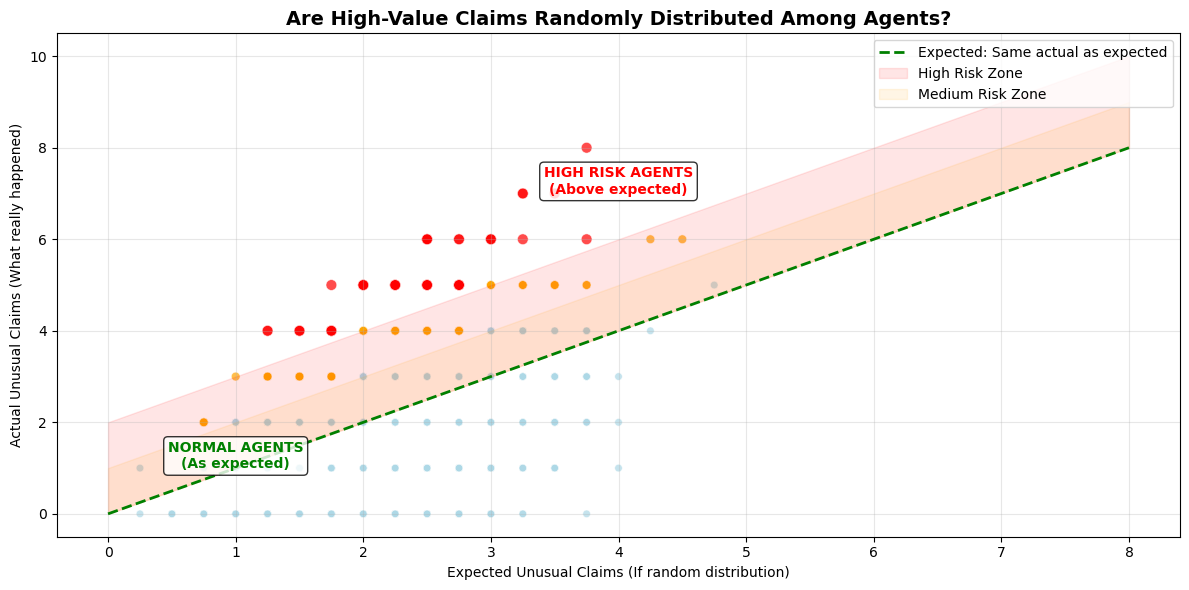


TOP AGENTS WITH MOST EXCESS UNUSUAL CLAIMS:
Agent ID     Total Claims  Expected   Actual   Excess  
-------------------------------------------------------
AGENT00525   15            4          8        4       
AGENT00182   13            3          7        4       
AGENT00679   13            3          7        4       
AGENT00125   10            2          6        4       
AGENT00400   10            2          6        4       
AGENT00807   14            4          7        4       
AGENT00838   10            2          6        4       
AGENT01196   10            2          6        4       
AGENT00037   7             2          5        3       
AGENT00219   11            3          6        3       
AGENT01027   11            3          6        3       
AGENT00439   12            3          6        3       
AGENT00446   8             2          5        3       
AGENT00485   12            3          6        3       
AGENT00528   8             2          5        3       

CO

In [32]:
# =============================================================================
# EXPECTED VS ACTUAL - ARE CLAIMS RANDOM?
# =============================================================================

print("\nIDEA 3: EXPECTED VS ACTUAL UNUSUAL CLAIMS")
print("=" * 50)

# Calculate expected unusual claims (25% of total claims)
agent_stats['EXPECTED_UNUSUAL'] = agent_stats['TOTAL_CLAIMS'] * 0.25
agent_stats['EXCESS_UNUSUAL'] = agent_stats['UNUSUAL_CLAIMS_COUNT'] - agent_stats['EXPECTED_UNUSUAL']

# Find agents with most excess unusual claims
high_excess_agents = agent_stats[agent_stats['EXCESS_UNUSUAL'] > 2]

print("Agents with 2+ more unusual claims than expected:", len(high_excess_agents))

# Visualize expected vs actual with better styling
plt.figure(figsize=(12, 6))

# Create color categories based on excess
colors = []
sizes = []
for idx, row in agent_stats.iterrows():
    excess = row['EXCESS_UNUSUAL']
    if excess > 2:
        colors.append('red')  # High excess - red
        sizes.append(60)      # Larger dots
    elif excess > 1:
        colors.append('orange')  # Medium excess - orange
        sizes.append(40)
    else:
        colors.append('lightblue')  # Normal - blue
        sizes.append(30)

plt.scatter(agent_stats['EXPECTED_UNUSUAL'], agent_stats['UNUSUAL_CLAIMS_COUNT'], 
           c=colors, alpha=0.7, s=sizes, edgecolors='white', linewidth=0.5)

# Expected line
plt.plot([0, 8], [0, 8], 'green', linestyle='--', linewidth=2, label='Expected: Same actual as expected')

# Add risk zones
plt.fill_between([0, 8], [0, 8], [2, 10], color='red', alpha=0.1, label='High Risk Zone')
plt.fill_between([0, 8], [0, 8], [1, 9], color='orange', alpha=0.1, label='Medium Risk Zone')

plt.xlabel('Expected Unusual Claims (If random distribution)')
plt.ylabel('Actual Unusual Claims (What really happened)')
plt.title('Are High-Value Claims Randomly Distributed Among Agents?', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotations
plt.text(4, 7, 'HIGH RISK AGENTS\n(Above expected)', color='red', fontweight='bold', 
         ha='center', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
plt.text(1, 1, 'NORMAL AGENTS\n(As expected)', color='green', fontweight='bold', 
         ha='center', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nTOP AGENTS WITH MOST EXCESS UNUSUAL CLAIMS:")
print("=" * 55)
excess_sorted = high_excess_agents.nlargest(15, 'EXCESS_UNUSUAL')
print(f"{'Agent ID':<12} {'Total Claims':<13} {'Expected':<10} {'Actual':<8} {'Excess':<8}")
print("-" * 55)

for agent_id, row in excess_sorted.iterrows():
    expected = int(round(row['EXPECTED_UNUSUAL']))
    actual = int(row['UNUSUAL_CLAIMS_COUNT'])
    excess = int(round(row['EXCESS_UNUSUAL']))
    
    print(f"{agent_id:<12} {int(row['TOTAL_CLAIMS']):<13} {expected:<10} {actual:<8} {excess:<8}")

print(f"\nCONCLUSION: {len(high_excess_agents)} agents handle significantly more high-value claims")
print("This proves unusual claims are NOT randomly distributed")

NOTES:

Color-coded risk zones (red for high risk, orange for medium, blue for normal)
Clear labels explaining what each axis means
Integer formatting for all numbers (no decimals)
Better sizing - high-risk agents appear as larger dots
Professional risk zones with shading
Clean table output with proper columns